## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.Transformer import *

from torchsampler import ImbalancedDatasetSampler

In [2]:
torch.manual_seed(109)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [4]:
size = 36
batch_size = 64
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), ToTensor()])

In [5]:
root = 'real_and_fake_face/train'
train_data = create_dataset(root, transformation)
train_loader = produce_loader(train_data, batch_size, shuffle=True)

In [6]:
root = 'real_and_fake_face/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [7]:
root = 'real_and_fake_face/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[2488, 1309, 2906, 401, 448, 990, 107, 3005, 1505]


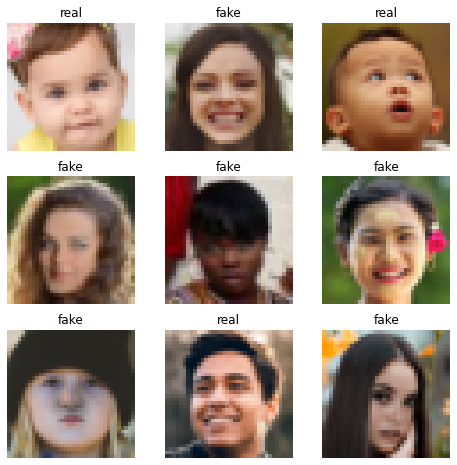

In [8]:
visualize_data(train_data)

[20, 153, 116, 22, 78, 16, 71, 52, 129]


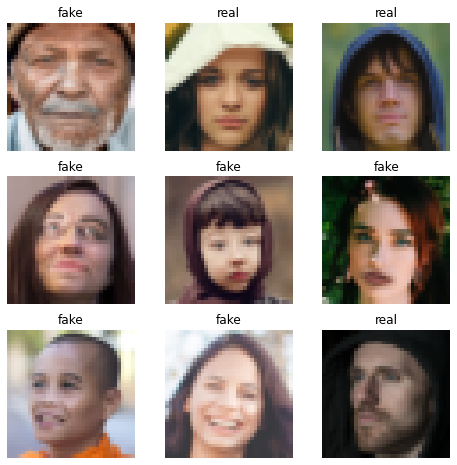

In [9]:
visualize_data(test_data)

## Initialize Model

In [10]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [11]:
from math import floor
# number of convolutional 'embedding' layers and their sizes
hidden = [3, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 5

# window size of maxpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]

In [12]:
model = Transformer(hidden, kernel_size, window, blocks).to(device)
print(model)

Transformer(
  (conv_combined): Sequential(
    (0): ConvEmbed(
      (conv): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): ConvEmbed(
      (conv): Conv2d(256, 64, kernel_size=(5, 5), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): ConvEmbed(
      (conv): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (blocks_combined): Sequential(
    (0): TransformerBlock(
      (attention): AttentionLayer(
        (query): Linear(in_features=4608, out_features=4608, bias=True)
       

## Training Model

In [13]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [14]:
optimizer = create_adam_optimizer(model, lr = 0.001)

In [15]:
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 20)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.484375
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.5182291666666666
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.5071022727272727
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.513671875
Epoch 1/20, Batch number: 20, Cumulated accuracy: 0.5089285714285714
Epoch 1/20, Batch number: 25, Cumulated accuracy: 0.5144230769230769
Epoch 1/20, Batch number: 30, Cumulated accuracy: 0.516633064516129
Epoch 1/20, Batch number: 35, Cumulated accuracy: 0.5091145833333334
Epoch 1/20, Batch number: 40, Cumulated accuracy: 0.5034298780487805
Epoch 1/20, Batch number: 45, Cumulated accuracy: 0.5054347826086957
Epoch 1/20, Batch number: 50, Cumulated accuracy: 0.5061274509803921
--- Epoch 1/20: Train loss: 0.7716, Train accuracy: 0.5064
--- Epoch 1/20: Val loss: 0.6938, Val accuracy: 0.4706
Epoch 2/20, Batch number: 0, Cumulated accuracy: 0.546875
Epoch 2/20, Batch number: 5, Cumulated accuracy: 0.4973958333333333
Epoch 2/20, Batch num

## Testing Model & Performance Curves

In [16]:
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)

Test loss: 0.6911, Test accuracy: 0.5343


Precision: 0.5585585585585585
Recall: 0.5740740740740741
F1 score: 0.5662100456621004


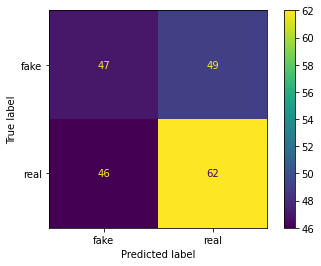

In [17]:
show_metrics(true_labels, model_preds)

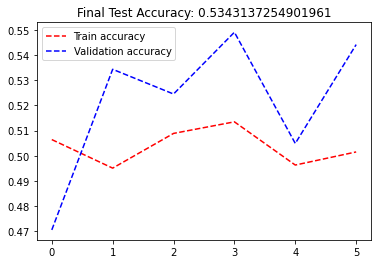

In [18]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

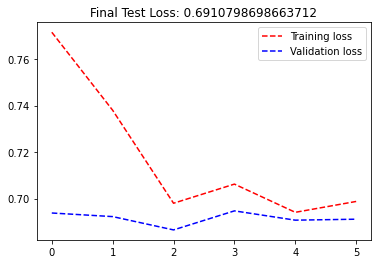

In [19]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [20]:
test_loader2 = produce_loader(test_data, 1)

In [21]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2)

Precision: 0.5652173913043478
Recall: 0.6018518518518519
F1 score: 0.5829596412556053


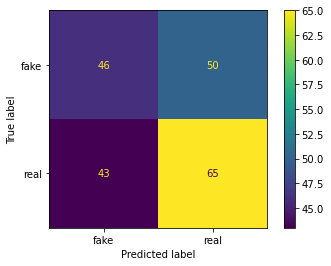

In [22]:
show_metrics(true_labels2, model_preds2)

[94, 98, 18, 37, 89, 80, 97, 70, 73, 99, 59, 46, 42, 76, 49, 104, 57, 78, 50, 44, 26, 41, 100, 62, 77]


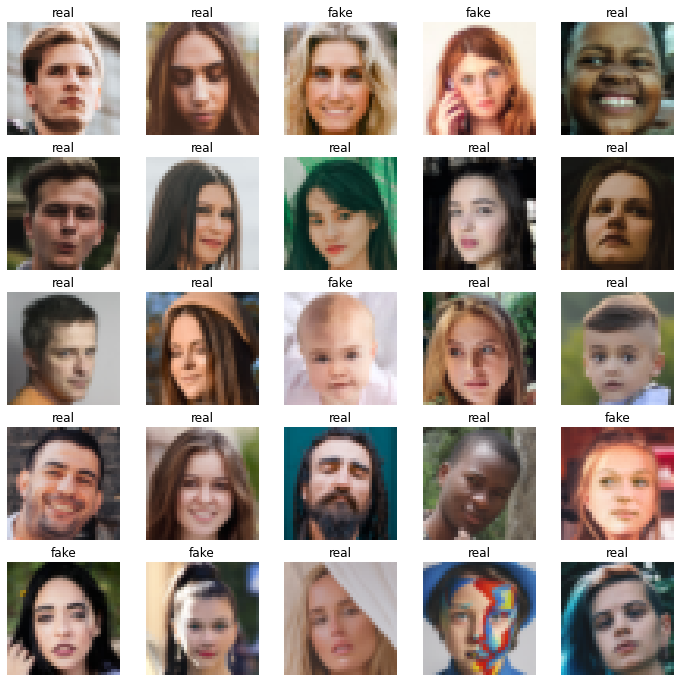

In [23]:
visualize_data(correct_list, (12,12), 5)

[4, 74, 67, 7, 51, 41, 76, 55, 26, 13, 51, 22, 80, 12, 69, 20, 66, 76, 39, 67, 26, 71, 71, 32, 30]


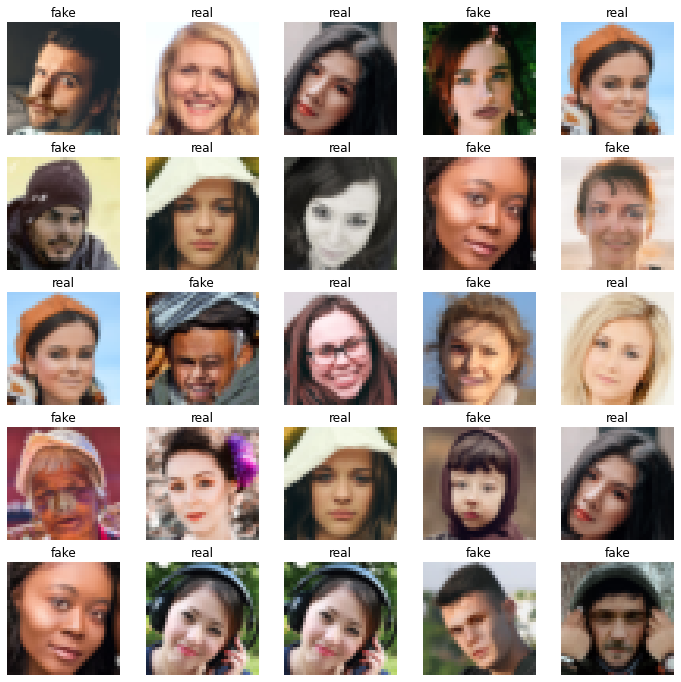

In [24]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './transformer_6epochs')